In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [172]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as sci
import halfspace.stress_comps_vectorized as scv
import halfspace.projections as hsp

import sys
sys.path.append('/Users/itchy/research/stress/aux_scripts/')
from stress_plots import rose, scatter_w_marginals

In [5]:
fault_file = '../data/fault_data/fault_pts_stresses.csv'

fd = pd.read_csv(fault_file, index_col=0)
fd.fault_name.fillna('nan', inplace=True)


fdf = fd[[False if 'aftershock' in fn else True for fn in fd.fault_name] ]

In [8]:
T_df = pd.read_csv('../results/T_results.csv', index_col=0)

In [20]:
T_df.head()

,txx,tyy,txy,likelihood,rel_likelihood,s1,s3,theta
iter,,,,,,,,
2,0.854166,0.373771,0.364815,157.759374,0.080634,1.050758,0.177180,241.680648
7,0.151238,0.145395,0.026907,1527.548470,0.780758,0.175382,0.121251,228.098413
28,-0.124724,0.999307,0.089178,834.695836,0.426628,1.006339,-0.131756,4.508137
32,-0.235468,1.946324,0.465035,1035.574922,0.529301,2.041308,-0.330452,11.543969
33,-0.076914,1.142021,-0.198089,380.150747,0.194302,1.173404,-0.108297,350.997412


In [9]:
fdf.head()

,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind,zz_stress,xy_stress,xz_stress,yz_stress,xx_stress,yy_stress,tau_dd,tau_ss,sig_nn
46,187652.100681,3201695.699761,-900,19.761917,55,0.1,-90,nan,46,30,72.782724,-20.708663,6.618130,-10.360121,108.028811,113.608322,26.380310,-10.230442,96.560053
47,182389.018021,3189482.756855,-905,19.761917,55,0.1,-90,nan,47,30,95.824706,-28.311916,2.546661,2.796005,116.195357,130.572758,19.305245,-23.639877,121.322763
48,177410.108366,3184445.612939,-952,19.761917,55,0.1,-90,nan,48,30,93.667997,-38.437273,0.959056,9.429767,116.008728,128.655159,21.887335,-32.859501,128.190738
49,173003.190810,3180027.682572,-1285,19.761917,55,0.1,-90,nan,49,30,104.706107,-28.472832,-4.574527,-7.554540,126.235864,113.490560,17.345927,-9.703697,131.979101
50,168449.167252,3177094.112030,-1284,19.761917,55,0.1,-90,nan,50,30,97.120548,-13.811391,13.318908,-16.027244,132.146107,116.011416,25.860193,1.547152,108.412460


In [14]:
fdf.fault_name.unique()

array(['nan', 'Kung Co fault', 'Ama Drime Detachment',
       'Nyonno Ri Detachment', 'Tingri fault', 'MHT_rupture'], dtype=object)

In [15]:
fdf.shape

(1044, 19)

In [17]:
mht_df = fdf[fdf.fault_name == 'MHT_rupture']

mht_df.shape

(109, 19)

In [18]:
mht_df.head()

,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind,zz_stress,xy_stress,xz_stress,yz_stress,xx_stress,yy_stress,tau_dd,tau_ss,sig_nn
1,371217.176384,2990476.582043,-1976.4,295,10,0.1372,78.2388,MHT_rupture,1,9999,5.084343,-3.941457,-0.406109,-0.607172,10.840858,3.350316,0.094292,-0.168028,5.228262
2,352953.546302,2999109.728820,-1976.4,295,10,0.1409,109.2604,MHT_rupture,2,9999,4.721721,-3.655790,-0.429189,-1.470961,10.794263,4.296803,1.070065,0.205045,5.177455
3,334724.026010,3007770.701491,-1976.4,295,10,0.0012,105.4416,MHT_rupture,3,9999,7.280446,-3.585615,-0.896945,-2.380615,12.845530,6.261112,1.940732,0.152534,8.069926
4,316518.527897,3016448.681931,-1976.4,295,10,0.0216,125.1266,MHT_rupture,4,9999,11.480763,-4.187917,-0.547796,-2.101331,13.842626,7.193640,0.928466,0.410859,12.021104
5,298337.362350,3025165.988086,-1976.4,295,10,0.1906,146.6912,MHT_rupture,5,9999,15.210190,-3.847594,-0.344587,-2.134074,15.701807,10.279623,0.772728,0.649468,15.713160


In [12]:
T_df.shape

(16652, 8)

In [105]:
rho = 2700
g = 9.81

def sample_mu():
    pass


def sample_phi():
    pass


def calc_S(row):
    
    rgz = np.abs(row.depth * 2700 * 9.81)
    
    T = hsp.make_xyz_stress_tensor(row.txx, row.txy, row.tyy) * rgz
    
    M = hsp.make_xyz_stress_tensor(row.mxx, row.myy, row.mzz, row.mxy,
                                   row.mxz, row.myz) * 1e6
    
    L = hsp.make_xyz_stress_tensor(sig_xx=rgz, sig_yy=rgz, sig_zz=rgz)
    
    return T + M + L


def calc_sig3(row):
    
    S = calc_S(row)
    
    vals, vecs = hsp.sorted_eigens(S)
    
    sig_3 = vals[0] / 1e6
    
    return sig_3


def check_hydrofrac(S, phi):
    
    sig_3 = calc_sig3(S)
    
    pressure = 1/3. * hsp.first_tensor_invariant(S)
    
    # phi * pressure > sig_3 -> hydrofrac
    return phi * pressure > sig_3


def get_pressure(mxx=0., myy=0., mzz=0., txx=0., tyy=0., depth=0.,
                rho=2700., g=9.81):

    rgz = np.abs(depth * rho * g) / 1e6
    
    return ((mxx + (txx * rgz) + rgz) 
            + (myy + (tyy * rgz) + rgz)
            + (mzz +  rgz) )  / 3.
    
    
def check_mc_failure(T_df, fdf, phi, mu, tau_dyn_s=0., tau_dyn_d=0., tau_dyn=0.):
    strike_shear = scv.strike_shear()
    dip_shear = scv.dip_shear()
    
    total_shear = np.sqrt((strike_shear**2 + dip_shear**2)) + tau_dyn
    
    sig_n_eff = scv.eff_normal_stress()
    
    return mu < total_shear / sig_n_eff
    
    
def check_intact_failure(T_df, fdf, phi, mu=0.6, tau_dyn_s=0., tau_dyn_d=0., tau_dyn=0.):
    strike_shear = scv.strike_shear()
    dip_shear = scv.dip_shear()
    
    total_shear = np.sqrt((strike_shear**2 + dip_shear**2)) + tau_dyn
    
    sig_n_eff = scv.eff_normal_stress()
    
    return mu < total_shear / sig_n_eff


def sample_fault_property_priors(n_trials, mu_range, phi_range):
    if np.isscalar(mu_range):
        mu = np.ones((n_trials,1)) * mu_range
    elif len(mu_range) == 2:
        mu = np.random.uniform(mu_range[0], mu_range[1], (n_trials,1))
    else:
        mu = sample_mu() # doesn't work
        
    if np.isscalar(phi_range):
        phi = np.ones((n_trials,1)) * phi_range
    elif len(phi_range) == 2:
        phi = np.random.uniform(phi_range[0], phi_range[1], (n_trials,1))
    else:
        phi = sample_phi() # doesn't work
        
    fault_properties = np.concatenate([mu, phi], axis=1)
    
    return fault_properties


def cat_fault_prop_priors(num_pts, n_trials, mu_range, phi_range, first_iter):
    
    fault_prop_priors = sample_fault_property_priors(n_trials, mu_range, phi_range)
    
    #run_ind = np.arange(n_trials) + first_iter
    
    #fault_prop_priors = np.hstack([fault_prop_priors, run_ind.reshape((n_trials, 1))])
    
    fault_prop_priors = np.repeat(fault_prop_priors, num_pts, axis=0)
    
    fault_prop_df = pd.DataFrame(fault_prop_priors, columns=['mu', 'phi'])
    
    return fault_prop_df
    

def make_params_mc_df(in_df, T_df, n_trials=1,  
               mu_range=0.6, phi_range=0.3,
               first_iter=0):
    
    num_pts = len(in_df.index)
    
    important_cols = ['strike', 'dip', 'rake', 'depth', 'slip_m',
                      'xx_stress', 'yy_stress', 'zz_stress',
                      'xy_stress', 'xz_stress', 'yz_stress']
    
    mc_df = pd.DataFrame( np.tile(in_df[important_cols].values, [n_trials, 1]),
                         columns=important_cols)
    
    fault_prop_df = cat_fault_prop_priors(num_pts, n_trials, mu_range, phi_range,
                                         first_iter)
    t_prior_df = cat_t_priors_params_inv(num_pts, n_trials, T_df, first_iter)
    
    mc_df = pd.concat((mc_df, fault_prop_df, t_prior_df), axis=1)
    
    del fault_prop_df
    
    mc_df.rename(columns={'xx_stress':'mxx', 'yy_stress':'myy', 'zz_stress':'mzz',
                          'xy_stress':'mxy', 'xz_stress':'mxz', 'yz_stress':'myz'},
                 inplace=True)
    return mc_df
    
    
def cat_t_priors_params_inv(num_pts, n_trials, T_df, first_iter):
    
    t_priors = sample_T_priors(n_trials, T_df)
    run_ind = np.arange(n_trials) + first_iter
    t_priors = np.hstack(( t_priors, run_ind.reshape([n_trials, 1]) ))
    t_priors = np.repeat(t_priors, num_pts, axis=0)
    
    t_prior_df = pd.DataFrame(t_priors, columns=['txx', 'tyy', 'txy', 'iter'])
    
    return t_prior_df
    
    
def sample_T_priors(n_trials, T_df):
    
    T_samples = T_df.ix[np.random.choice(T_df.index.values, n_trials), 
                        ('txx', 'tyy', 'txy')]
    
    return T_samples.values


def get_total_stresses_params_inv(mc_df, rho, g):
    
    mc_df['tau_s'] = scv.strike_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1) / 1e6
    
    mc_df['tau_d'] = scv.dip_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1) / 1e6
    
    mc_df['pressure'] = get_pressure(mxx=mc_df.mxx, myy=mc_df.myy, mzz=mc_df.mzz,
                                     txx=mc_df.txx, tyy=mc_df.tyy, depth=mc_df.depth)
    
    mc_df['sig_n'] = scv.eff_normal_stress(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1,
                                      phi=0.) / 1e6
    
    mc_df['sigma_3'] = mc_df.apply(calc_sig3, axis=1)
    
    return mc_df

In [106]:
mc_df = make_mc_df(mht_df, T_df, n_trials=10, mu_range=[0., 0.7], phi_range=[0., 1.])

In [107]:
mc_df.head()

,strike,dip,rake,depth,slip_m,mxx,myy,mzz,mxy,mxz,myz,mu,phi,txx,tyy,txy,iter
0,295,10,78.2388,-1976.4,0.1372,10.840858,3.350316,5.084343,-3.941457,-0.406109,-0.607172,0.133967,0.114299,0.895898,1.624026,-0.552903,0
1,295,10,109.2604,-1976.4,0.1409,10.794263,4.296803,4.721721,-3.655790,-0.429189,-1.470961,0.133967,0.114299,0.895898,1.624026,-0.552903,0
2,295,10,105.4416,-1976.4,0.0012,12.845530,6.261112,7.280446,-3.585615,-0.896945,-2.380615,0.133967,0.114299,0.895898,1.624026,-0.552903,0
3,295,10,125.1266,-1976.4,0.0216,13.842626,7.193640,11.480763,-4.187917,-0.547796,-2.101331,0.133967,0.114299,0.895898,1.624026,-0.552903,0
4,295,10,146.6912,-1976.4,0.1906,15.701807,10.279623,15.210190,-3.847594,-0.344587,-2.134074,0.133967,0.114299,0.895898,1.624026,-0.552903,0


In [108]:
#%%timeit
mc_df = get_total_stresses(mc_df, rho, g)

In [111]:
mc_df.tail()

,strike,dip,rake,depth,slip_m,mxx,myy,mzz,mxy,mxz,...,phi,txx,tyy,txy,iter,tau_s,tau_d,pressure,sig_n,sigma_3
1085,295,10,116.6497,-25418.9,0.0124,63.904369,59.036048,119.203595,-2.180603,-7.139592,...,0.040009,-0.857015,1.257039,-0.001895,9,93.771397,104.578436,843.759793,813.525018,160.128622
1086,295,10,148.7252,-25418.9,0.5737,64.220058,59.736019,119.311943,-2.080170,-4.923293,...,0.040009,-0.857015,1.257039,-0.001895,9,95.812445,103.900247,844.134462,813.367274,160.463309
1087,295,10,146.4999,-25418.9,1.0966,65.232809,60.383388,121.089218,-1.865776,-3.153830,...,0.040009,-0.857015,1.257039,-0.001895,9,97.557172,103.480733,845.280260,815.020752,161.487337
1088,295,10,139.0376,-25418.9,0.6191,66.366512,60.968335,125.376011,-1.113010,-1.268758,...,0.040009,-0.857015,1.257039,-0.001895,9,98.687646,101.331461,847.282074,818.622413,162.630754
1089,295,10,88.8753,-25418.9,0.1040,66.618251,61.689384,130.352953,-0.858830,-0.668940,...,0.040009,-0.857015,1.257039,-0.001895,9,98.339569,98.570852,849.265318,822.727583,162.884187


In [213]:
def intact_failure(row):
    S = calc_S(row)
    
    sig_n = hsp.normal_stress_on_optimal_plane(S)
    tau = hsp.shear_stress_on_optimal_plane(S)[0]
    
    return tau > 0.6 * (sig_n - (row.pressure * row.phi))


def hit_or_miss(mc_df, slip_err=0.1):
    
    slip_cond = ( (mc_df.mc_failure & (mc_df.slip_m > 0.05) ) |
                  (~ mc_df.mc_failure & (mc_df.slip_m < slip_err)))
    
    frac_cond = ~ mc_df.frac
    intact_fail_cond = ~ mc_df.intact_failure
    
    return (slip_cond & frac_cond & intact_fail_cond)
                
                
def calc_likelihood(mc_df):

    mc_df['hit'] = hit_or_miss(mc_df)
    
    num_hits = mc_df.groubpy('iters').hit.sum()

    return num_hits
    
    



In [214]:
def do_fault_prop_calcs(mht_df, T_df, n_trials=100, mu_range=0.6, phi_range=0.3,
                       first_iter=0):
    
    mc_df = make_mc_df(mht_df, T_df, n_trials, mu_range, phi_range, first_iter)
    
    mc_df = get_total_stresses(mc_df, rho, g)
    
    mc_df['mc_failure'] = (np.sqrt( (mc_df.tau_s**2 + mc_df.tau_d**2) ) > 
                       mc_df.mu * (mc_df.sig_n - (mc_df.pressure * mc_df.phi) ))

    mc_df['intact_failure'] = mc_df.apply(intact_failure, axis=1)

    mc_df['frac'] = mc_df.phi * mc_df.pressure > mc_df.sigma_3
    
    mc_df['hit'] = hit_or_miss(mc_df)
    
    iters = mc_df.groupby('iter')
    
    like_df = pd.DataFrame(index = iters['iter'].mean(),
                          columns = ['txx', 'tyy', 'txy',
                                     'mu', 'phi', 'num_hits'])
    
    like_df.mu = iters.mu.mean()
    like_df.phi = iters.phi.mean()
    like_df.num_hits = iters.hit.sum()
    like_df.txx = iters.txx.mean()
    like_df.txy = iters.txy.mean()
    like_df.tyy = iters.tyy.mean()
    
    return like_df
    
    

In [168]:
#%%timeit
like_df = do_fault_prop_calcs(mht_df, T_df, n_trials=1000,
                              mu_range=[0., 0.6], phi_range=[0., 0.8])

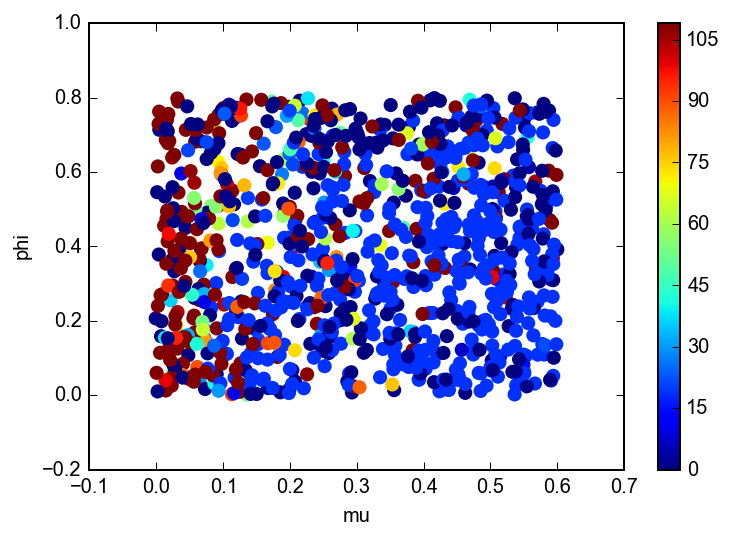

In [169]:
plt.scatter(like_df.mu, like_df.phi,
           c=like_df.num_hits,
           s=50, lw=0)
plt.colorbar()
plt.xlabel('mu')
plt.ylabel('phi')

In [223]:
t_start = time.time()

np.random.seed(69)

n_mcs = 10000

trials_per_loop = 100

n_loops = int(n_mcs / trials_per_loop)

likes = {}

for i in range(n_loops):
    
    first_iter = i * trials_per_loop
    
    likes[i] = do_fault_prop_calcs(mht_df, T_df, n_trials=trials_per_loop,
                              mu_range=[0., 0.8], phi_range=[0., 1.],
                                   first_iter=first_iter)
    if i % 10 == 0:
        print(i)
    
t_end = time.time()

print('done in', int((t_end - t_start) / 60 ), 'm')

0
10
20
30
40
50
60
70
80
90
done in 19 m


In [230]:
like_df = pd.concat([li for li in likes.values()])

In [225]:
like_df.describe()

,txx,tyy,txy,mu,phi,num_hits
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.001705,0.822241,0.340339,0.399580,0.495452,27.64210
std,0.725898,0.785216,0.553695,0.231266,0.290195,33.53699
min,-2.713661,-0.470507,-1.694281,0.000071,0.000119,0.00000
25%,-0.248152,0.143088,-0.000523,0.197301,0.238739,0.00000
50%,0.027673,0.558454,0.120861,0.400578,0.488684,19.00000
75%,0.212361,1.379059,0.582823,0.599613,0.745513,22.00000
max,2.962082,2.995744,2.874279,0.799850,0.999800,96.00000


In [226]:
filt = np.random.uniform(size=n_mcs)

keeps = like_df[like_df.num_hits / 109 > filt]

In [227]:
keeps.shape

(2576, 6)

In [228]:
keeps.describe()

,txx,tyy,txy,mu,phi,num_hits
count,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000,2576.000000
mean,0.270451,0.638087,0.378133,0.315115,0.484504,68.008540
std,0.478188,0.624166,0.498752,0.235170,0.266392,34.233203
min,-0.634564,-0.199893,-0.472874,0.000071,0.000119,1.000000
25%,0.001442,0.133764,0.008552,0.106414,0.261707,19.000000
50%,0.117300,0.416809,0.164455,0.274440,0.498035,95.000000
75%,0.396330,0.993017,0.611637,0.511925,0.705888,96.000000
max,2.758547,2.898726,2.459530,0.799179,0.998348,96.000000


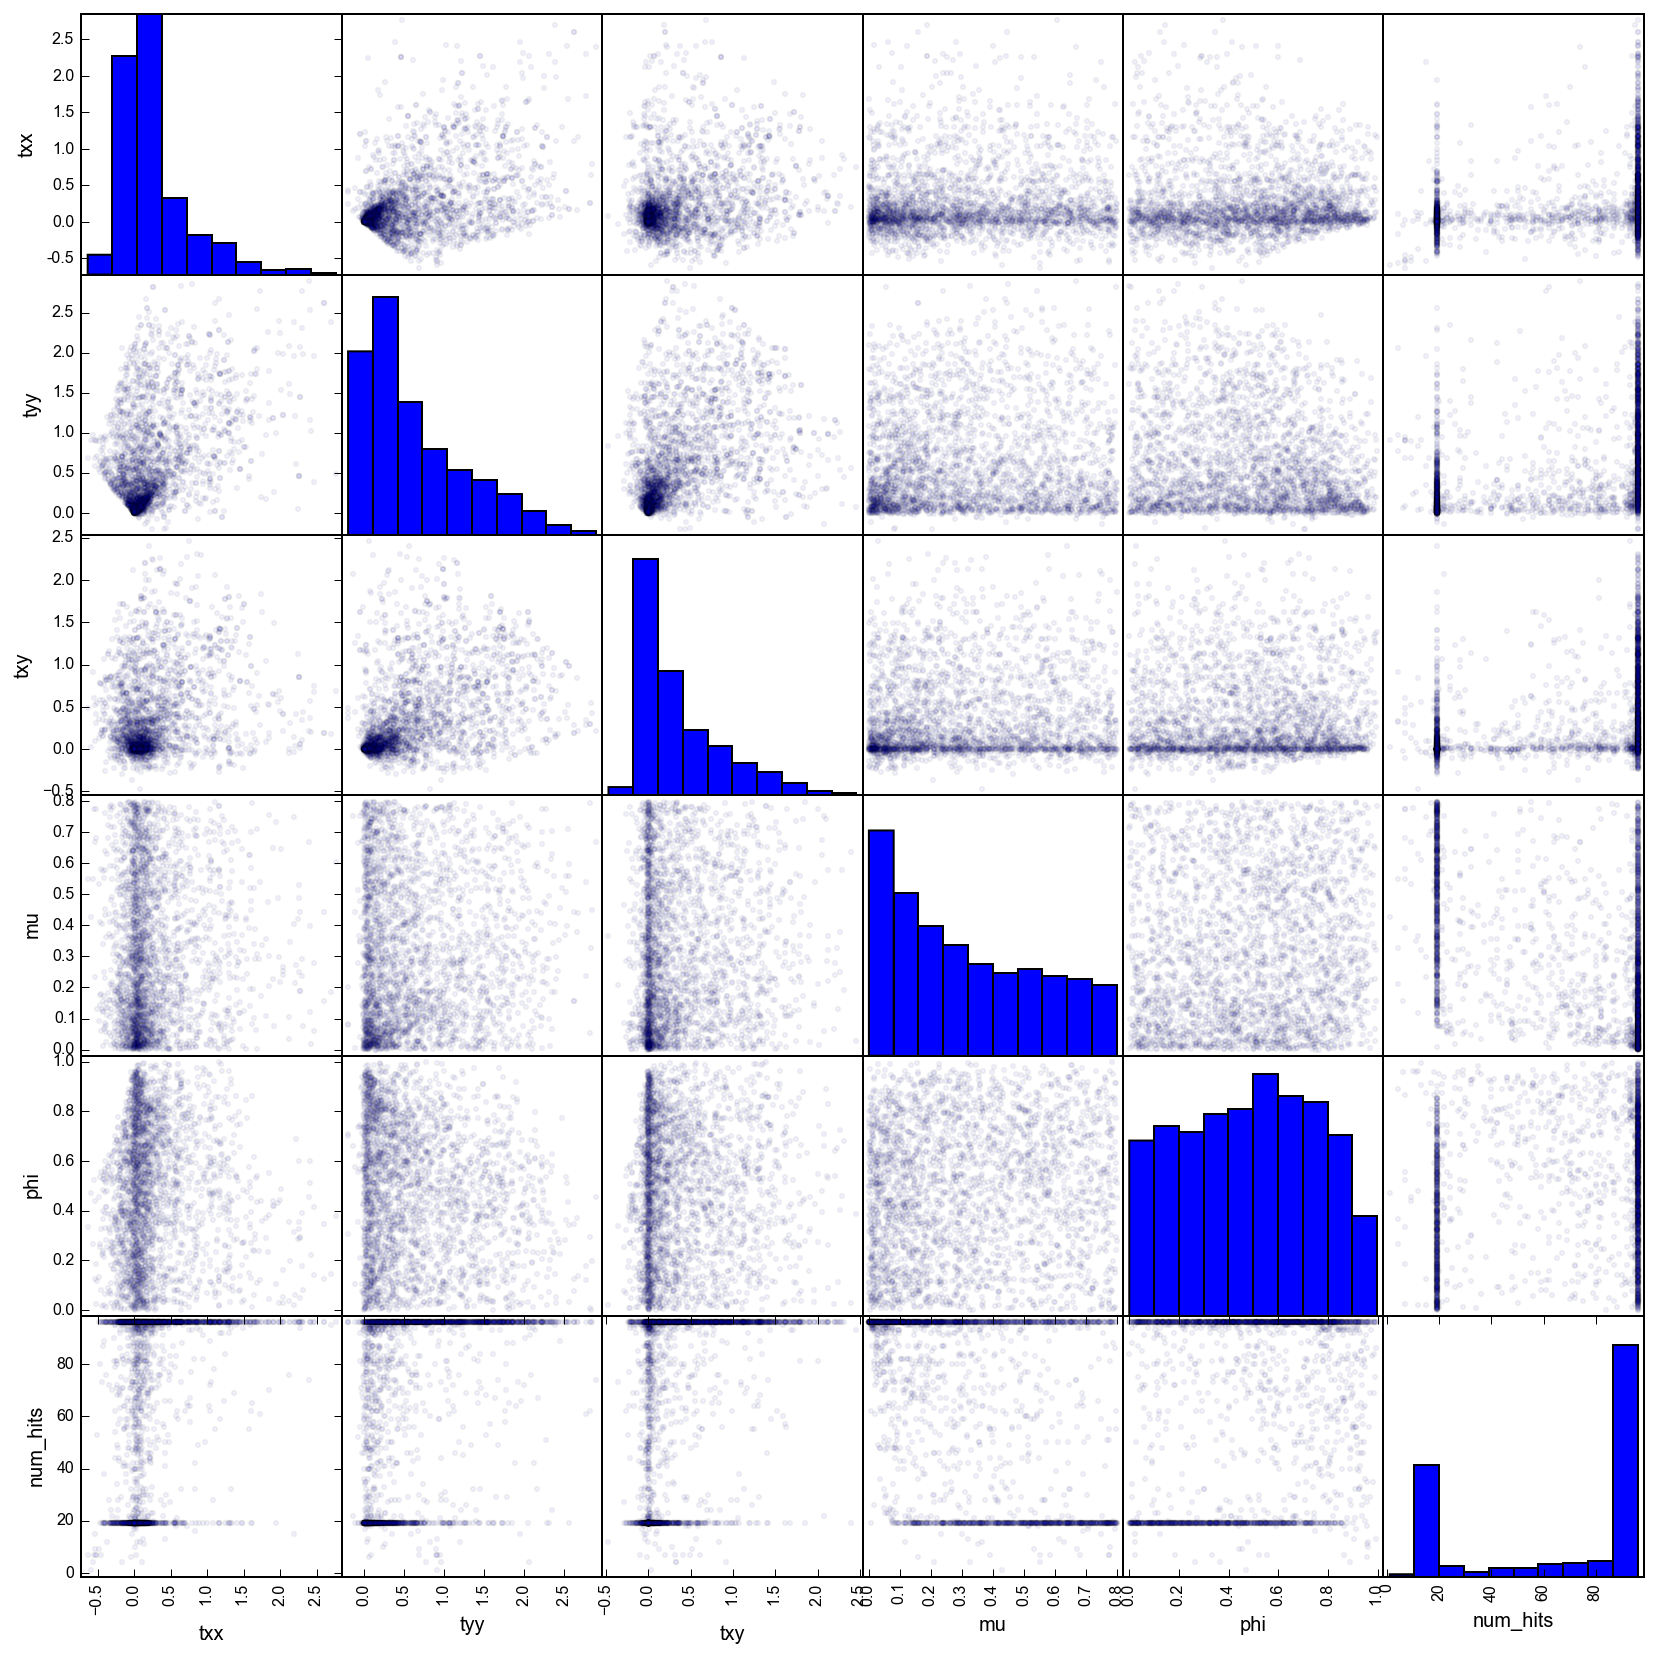

In [233]:
pd.tools.plotting.scatter_matrix(keeps, alpha=0.05, figsize=(14,14))

plt.show()

In [231]:
keeps.iloc[0]

txx          0.228831
tyy          0.230090
txy          0.001261
mu           0.046769
phi          0.845677
num_hits    93.000000
Name: 7.0, dtype: float64

In [199]:
mc_df.groupby('iter').hit.sum().head()

iter
0     72
1    109
2     19
3     19
4      0
Name: hit, dtype: float64

In [234]:
mc_df

,strike,dip,rake,depth,slip_m,mxx,myy,mzz,mxy,mxz,...,iter,tau_s,tau_d,pressure,sig_n,sigma_3,mc_failure,intact_failure,frac,hit
0,295,10,78.2388,-1976.4,0.1372,10.840858,3.350316,5.084343,-3.941457,-0.406109,...,0,-0.134859,1.041679,61.587888,57.744219,55.135115,False,False,False,False
1,295,10,109.2604,-1976.4,0.1409,10.794263,4.296803,4.721721,-3.655790,-0.429189,...,0,0.238213,2.017452,61.766978,57.693411,55.853435,True,False,False,True
2,295,10,105.4416,-1976.4,0.0012,12.845530,6.261112,7.280446,-3.585615,-0.896945,...,0,0.185702,2.888118,63.958412,60.585883,57.370064,True,False,False,True
3,295,10,125.1266,-1976.4,0.0216,13.842626,7.193640,11.480763,-4.187917,-0.547796,...,0,0.444027,1.875853,66.001725,64.537061,58.346755,False,False,False,True
4,295,10,146.6912,-1976.4,0.1906,15.701807,10.279623,15.210190,-3.847594,-0.344587,...,0,0.682637,1.720115,68.893256,68.229117,61.537258,False,False,False,False
5,295,10,132.1302,-1976.4,0.0277,14.447405,10.127162,13.019164,-3.481754,-0.539343,...,0,0.391483,1.853847,67.693960,66.018673,61.501526,False,False,False,True
6,295,10,140.9330,-1976.4,0.0510,13.542407,9.250464,11.995393,-2.713911,0.054637,...,0,-0.739093,-1.483928,66.758803,63.756619,61.082853,False,False,False,True
7,295,10,147.0974,-1976.4,0.0013,11.062416,6.095557,5.125737,-1.720097,-0.186430,...,0,-0.306890,1.041397,62.590619,57.658606,58.947062,False,False,False,True
8,295,10,138.1288,-1976.4,0.0370,11.780934,5.789424,4.521473,-1.003814,0.023560,...,0,0.064915,1.814463,62.526659,57.302669,58.756968,True,False,False,True
9,295,10,128.0197,-1976.4,0.0367,19.076925,13.417380,16.431436,-0.422437,1.468395,...,0,2.744556,3.506487,71.471296,69.953494,64.774280,True,False,False,True


In [202]:
m1 = mc_df[mc_df['iter']==1]

In [204]:
m1_mc = (np.sqrt( (m1.tau_s**2 + m1.tau_d**2) ) / 
          m1.mu * (m1.sig_n - (m1.pressure * m1.phi) ))

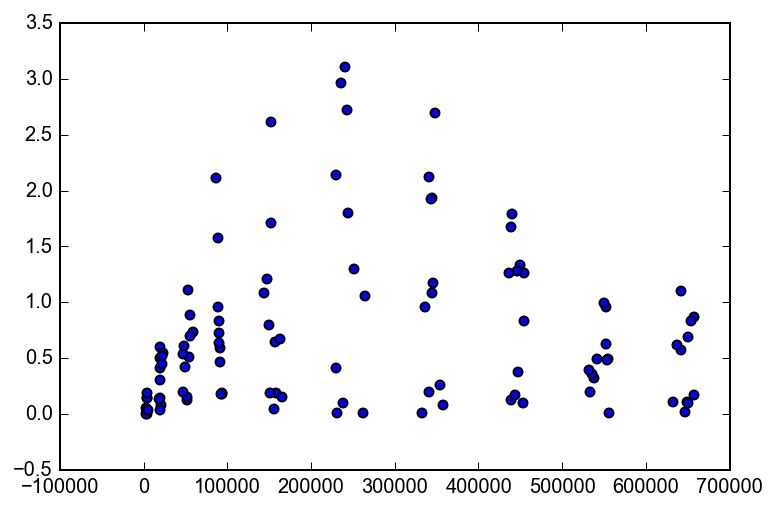

In [205]:
plt.scatter(m1_mc, m1.slip_m)

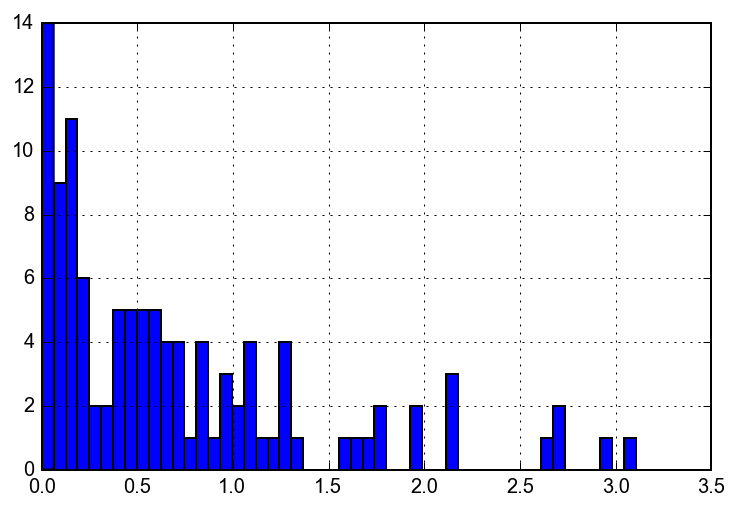

In [209]:
m1.slip_m.hist( bins=50)

In [211]:
sum(m1.slip_m < 0.1)

19

In [212]:
m1.slip_m.min()

0.0012